To do

- [ ] check if inheriting from `dict` like [here](https://github.com/cython/cython/wiki/ListExample) is not a better idea
- [ ] should be use `double` or `float`?
- [ ] what is `Pxy_DECREF` in `dot_dict`?

In [1]:
import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIG_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIG_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIG_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

%matplotlib inline
%config InlineBackend.figure_format='retina'

We want to speed up the manipulation of Python dicts. The keys can be of any type, whilst the values are always floats. Let's first make a helper function to generate random dicts of a given size.

In [2]:
import random

def rand_dict(size):
    return {i: random.random() for i in range(size)}

rand_dict(2)

{0: 0.4224063210410265, 1: 0.30329846762413903}

## Dot product

Let's start by benchmarking a dot product, because that's a pretty common operation in machine learning. We'll store the benchmarks in a dictionary.

In [3]:
dot_bench = {}

We're interested in dicts of all sizes, so we'll benchmark a few sizes that are fairly common to encounter.

In [4]:
sizes = [2, 3, 5, 8, 10, 15, 20, 25, 30, 50, 75, 100, 125, 150, 175, 200]

Let's first benchmark a basic Python implementation. This is the baseline which we want to improve on.

In [5]:
def py_dot(x: dict, y: dict) -> float:
    return sum(xi * y[i] for i, xi in x.items())

dot_bench['Python'] = {}

for size in sizes:
    x = rand_dict(size)
    y = rand_dict(size)
    dot_bench['Python'][size] = %timeit -o -q py_dot(x, y)
    print(size, dot_bench['Python'][size])

2 617 ns ± 2.14 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
3 775 ns ± 60.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
5 972 ns ± 123 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
8 1.12 µs ± 57.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
10 1.31 µs ± 88.3 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
15 2 µs ± 391 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
20 2.49 µs ± 255 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
25 2.85 µs ± 202 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
30 3.76 µs ± 133 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
50 4.41 µs ± 388 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
75 5.71 µs ± 179 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
100 7.5 µs ± 127 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
125 9.85 µs ± 1.49 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each

How about numpy? It might be fast, but it requires converting the dictionary values to a numpy array.

In [15]:
import numpy as np

def np_dot(x: dict, y: dict) -> float:
    return np.dot(np.fromiter(x.values(), dtype=float), np.fromiter(y.values(), dtype=float))
    
dot_bench['Numpy'] = {}

for size in sizes:
    x = rand_dict(size)
    y = rand_dict(size)
    dot_bench['Numpy'][size] = %timeit -o -q np_dot(x, y)
    print(size, dot_bench['Numpy'][size])

2 2.77 µs ± 331 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
3 2.55 µs ± 318 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
5 2.28 µs ± 134 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
8 2.5 µs ± 85 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
10 2.44 µs ± 40.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
15 2.9 µs ± 281 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
20 3.33 µs ± 456 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
25 3.4 µs ± 475 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
30 4.19 µs ± 479 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
50 4.93 µs ± 750 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
75 5.28 µs ± 336 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
100 6.47 µs ± 527 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
125 7.82 µs ± 981 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
150 

Now let's implement a Cython dictionary.

In [4]:
%load_ext Cython

In [14]:
%%cython --annotate
# distutils: language = c++

cimport cython

# C++
from cython.operator cimport dereference as deref
from cython.operator cimport preincrement as inc
from libcpp.map cimport map as cpp_map

ctypedef int   KTYPE_t
ctypedef float VTYPE_t

cdef class IntFloatDict:
    
    cdef cpp_map[KTYPE_t, VTYPE_t] data

    def __init__(self, d not None):
        
        cdef KTYPE_t k
        cdef VTYPE_t v
        
        for k, v in d.items():
            self.data[k] = v
            
    def __getitem__(self, KTYPE_t k):
        cdef cpp_map[KTYPE_t, VTYPE_t].iterator it = self.data.find(k)
        if it == self.data.end():
            raise KeyError('%i' % k)
        return deref(it).second
            
    def __setitem__(self, KTYPE_t k, VTYPE_t v):
        self.data[k] = v
            
    def dot(self, IntFloatDict other):
        cdef VTYPE_t total
        cdef KTYPE_t k
        cdef cpp_map[KTYPE_t, VTYPE_t].iterator it = other.data.begin()
        cdef cpp_map[KTYPE_t, VTYPE_t].iterator end = other.data.end()
        
        while it != end:
            k = deref(it).first
            total += self.data[k] * other.data[k]
            inc(it)
        
        return total
    
    def dot_dict(self, dict other not None):
        cdef VTYPE_t total
        cdef KTYPE_t k
        cdef VTYPE_t v
        
        for k, v in other.items():
            total += self.data[k] * v
        
        return total
    
    @cython.boundscheck(False)
    @cython.wraparound(False)
    def dot_list(self, list keys not None, list values not None):
        cdef VTYPE_t total
        cdef KTYPE_t k
        cdef VTYPE_t v
        
        cdef int i
        cdef int size = len(values)
        
        for i in range(size):
            k = keys[i]
            v = values[i]
            total += self.data[k] * v
        
        return total
    
    def sub_dict(self, dict other not None):
        cdef KTYPE_t k
        cdef VTYPE_t v
        
        for k, v in other.items():
            self.data[k] -= v
            
    def sub(self, IntFloatDict other):
        cdef KTYPE_t k
        cdef cpp_map[KTYPE_t, VTYPE_t].iterator it = other.data.begin()
        cdef cpp_map[KTYPE_t, VTYPE_t].iterator end = other.data.end()
        
        while it != end:
            k = deref(it).first
            self.data[k] -= other.data[k]
            inc(it)

In [13]:
x = IntFloatDict(rand_dict(30))
y = rand_dict(30)
%timeit x.dot_dict(y)

711 ns ± 7.74 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [ ]:
433 ns ± 15.8 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)

In [9]:
def cython_dot(x: IntFloatDict, y: dict) -> float:
    return x.dot(IntFloatDict(y))
    
dot_bench['Cython'] = {}

for size in sizes:
    x = IntFloatDict(rand_dict(size))
    y = rand_dict(size)
    dot_bench['Cython'][size] = %timeit -o -q cython_dot(x, y)
    print(size, dot_bench['Cython'][size])

2 411 ns ± 1.21 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
3 561 ns ± 33.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
5 785 ns ± 5.75 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
8 1.42 µs ± 145 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
10 1.57 µs ± 57.3 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
15 2.25 µs ± 183 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
20 3.7 µs ± 440 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
25 3.78 µs ± 305 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
30 4.77 µs ± 444 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
50 9.59 µs ± 741 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
75 13.2 µs ± 1.12 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
100 17.8 µs ± 1.37 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
125 20.7 µs ± 312 ns per loop (mean ± std. dev. of 7 runs, 10000 loops e

In [10]:
def cython_dot_from_dict(x: IntFloatDict, y: dict) -> float:
    return x.dot_dict(y)
    
dot_bench['Cython from dict'] = {}

for size in sizes:
    x = IntFloatDict(rand_dict(size))
    y = rand_dict(size)
    dot_bench['Cython from dict'][size] = %timeit -o -q cython_dot_from_dict(x, y)
    print(size, dot_bench['Cython from dict'][size])

2 144 ns ± 5.5 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
3 157 ns ± 7.58 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
5 187 ns ± 6.29 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
8 210 ns ± 1.86 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
10 245 ns ± 22.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
15 328 ns ± 40.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
20 353 ns ± 3.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
25 463 ns ± 36.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
30 518 ns ± 49.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
50 880 ns ± 70.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
75 1.14 µs ± 34.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
100 1.96 µs ± 110 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
125 2.36 µs ± 185 ns per loop (mean ± std. dev. of 7 runs, 100000

In [16]:
def cython_dot_from_lists(x: IntFloatDict, y: dict) -> float:
    return x.dot_list(list(y.keys()), list(y.values()))
    
dot_bench['Cython from lists'] = {}

for size in sizes:
    x = IntFloatDict(rand_dict(size))
    y = rand_dict(size)
    dot_bench['Cython from lists'][size] = %timeit -o -q cython_dot_from_lists(x, y)
    print(size, dot_bench['Cython from lists'][size])

2 595 ns ± 26.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
3 663 ns ± 37.3 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
5 649 ns ± 46.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
8 692 ns ± 38.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
10 706 ns ± 48.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
15 774 ns ± 27.8 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
20 897 ns ± 60.3 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
25 962 ns ± 61.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
30 1.08 µs ± 77.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
50 1.36 µs ± 13.8 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
75 2.06 µs ± 21.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
100 2.49 µs ± 32.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
125 2.96 µs ± 19.2 ns per loop (mean ± std. dev. of 7 runs, 10000

Let's plot these results.

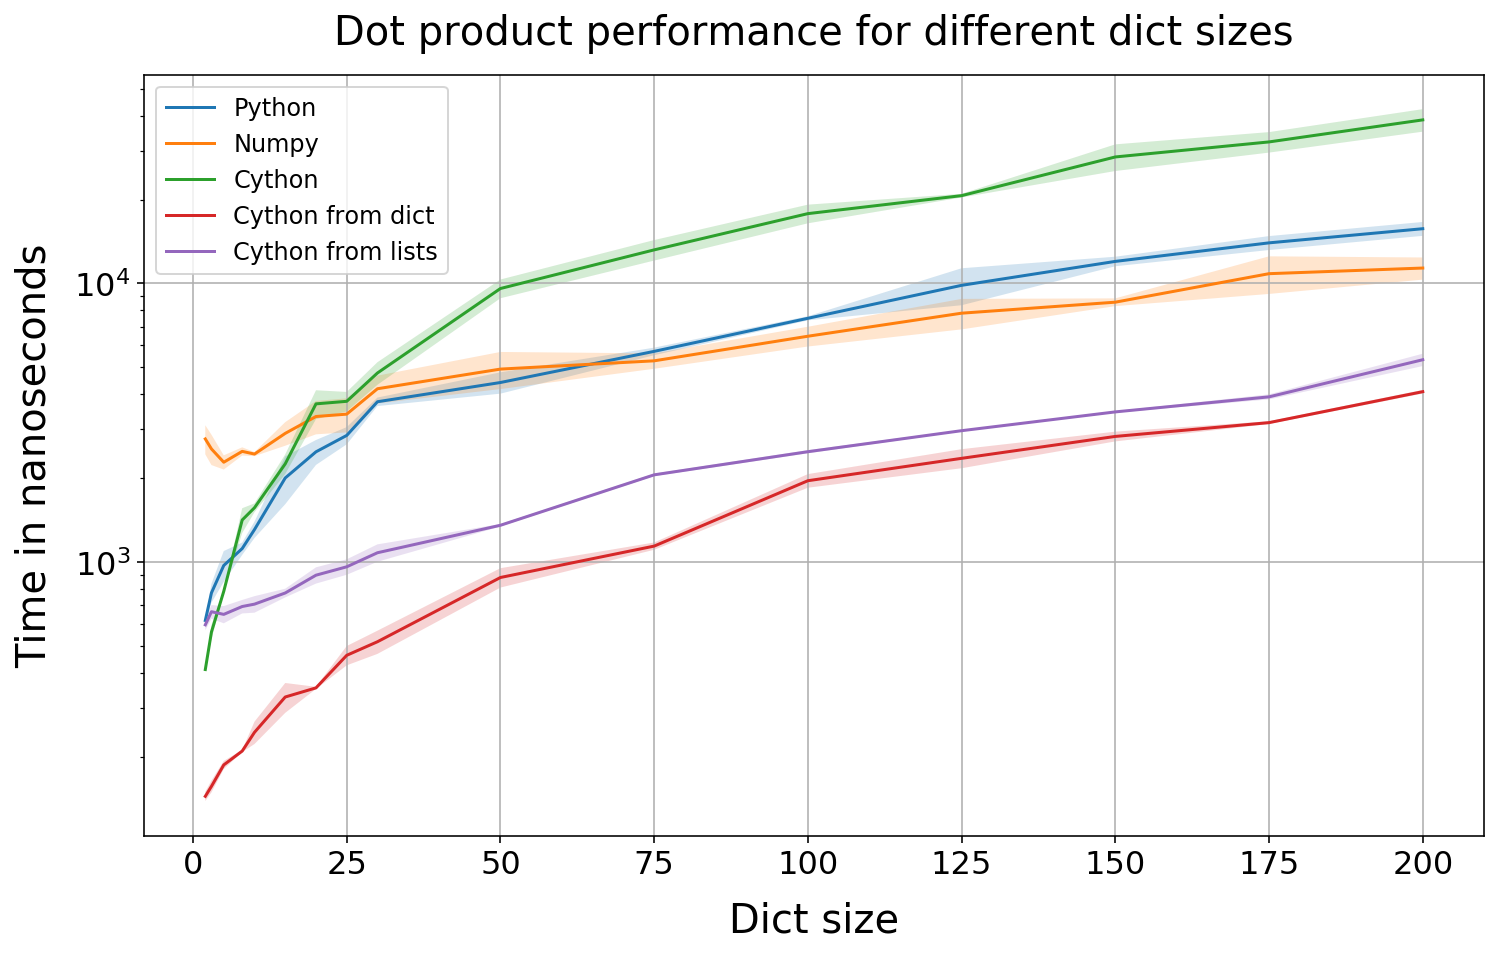

In [17]:
fig, ax = plt.subplots(figsize=(12, 7))

for method, time_results in dot_bench.items():
    avgs = [1e9 * tr.average for tr in time_results.values()]
    stds = [1e9 * tr.stdev   for tr in time_results.values()]
    lower = [avg - std for avg, std in zip(avgs, stds)]
    upper = [avg + std for avg, std in zip(avgs, stds)]
    ax.fill_between(list(time_results.keys()), lower, upper, interpolate=True, alpha=.2)
    ax.plot(list(time_results.keys()), avgs, label=method)
    
ax.legend()
ax.grid()
ax.set_title('Dot product performance for different dict sizes', pad=15)
ax.set_xlabel('Dict size', labelpad=10)
ax.set_ylabel('Time in nanoseconds', labelpad=10)
ax.set_yscale('log')
fig.savefig('dotprod_perf.png')

## Subtract

Another common task is to subtract a gradient to a set weights.

In [18]:
sub_bench = {}

Let's give this a first go in Python.

In [19]:
def py_sub(w: dict, g: dict):
    for i, gi in g.items():
        w[i] -= gi
        
sub_bench['Python'] = {}
        
for size in sizes:
    w = rand_dict(size)
    g = rand_dict(size)
    sub_bench['Python'][size] = %timeit -o -q py_sub(w, g)
    print(size, sub_bench['Python'][size])

2 328 ns ± 3.34 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
3 396 ns ± 2.59 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
5 581 ns ± 29.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
8 797 ns ± 44.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
10 902 ns ± 14.7 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
15 1.32 µs ± 125 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
20 1.54 µs ± 21 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
25 1.86 µs ± 7.91 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
30 2.26 µs ± 49.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
50 3.59 µs ± 47.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
75 5.16 µs ± 72.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
100 7.19 µs ± 56 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
125 9.07 µs ± 73.1 ns per loop (mean ± std. dev. of 7 runs, 100000 lo

Now let's see how our Cython dict performs.

In [20]:
def cython_sub_py_loop(w: IntFloatDict, g: dict):
    for i, gi in g.items():
        w[i] -= gi
        
sub_bench['Cython w/ Python loop'] = {}
        
for size in sizes:
    w = IntFloatDict(rand_dict(size))
    g = rand_dict(size)
    sub_bench['Cython w/ Python loop'][size] = %timeit -o -q cython_sub_py_loop(w, g)
    print(size, sub_bench['Cython w/ Python loop'][size])

2 318 ns ± 3.13 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
3 382 ns ± 3.52 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
5 530 ns ± 18.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
8 705 ns ± 12.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
10 851 ns ± 3.7 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
15 1.24 µs ± 9.79 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
20 1.56 µs ± 62.7 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
25 2.06 µs ± 186 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
30 2.47 µs ± 224 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
50 4.05 µs ± 242 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
75 6.08 µs ± 349 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
100 8.44 µs ± 501 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
125 11.2 µs ± 987 ns per loop (mean ± std. dev. of 7 runs, 100000 loops

In [22]:
def cython_sub_from_dict(w: IntFloatDict, g: dict):
    w.sub_dict(g)
        
sub_bench['Cython from dict'] = {}
        
for size in sizes:
    w = IntFloatDict(rand_dict(size))
    g = rand_dict(size)
    sub_bench['Cython from dict'][size] = %timeit -o -q cython_sub_from_dict(w, g)
    print(size, sub_bench['Cython from dict'][size])

2 151 ns ± 2.06 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
3 169 ns ± 4.48 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
5 199 ns ± 8.79 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
8 259 ns ± 20.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
10 278 ns ± 25.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
15 347 ns ± 2.56 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
20 416 ns ± 2.41 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
25 511 ns ± 1.39 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
30 627 ns ± 43.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
50 935 ns ± 8.98 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
75 1.42 µs ± 7.09 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
100 2.14 µs ± 80.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
125 2.69 µs ± 46.2 ns per loop (mean ± std. dev. of 7 runs, 10000

In [23]:
def cython_sub(w: IntFloatDict, g: dict):
    w.sub(IntFloatDict(g))
        
sub_bench['Cython'] = {}
        
for size in sizes:
    w = IntFloatDict(rand_dict(size))
    g = rand_dict(size)
    sub_bench['Cython'][size] = %timeit -o -q cython_sub(w, g)
    print(size, sub_bench['Cython'][size])

2 459 ns ± 32.8 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
3 648 ns ± 60.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
5 915 ns ± 48.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
8 1.34 µs ± 45.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
10 1.57 µs ± 46.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
15 2.28 µs ± 58 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
20 3.1 µs ± 29.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
25 3.82 µs ± 95.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
30 4.74 µs ± 31.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
50 8.36 µs ± 583 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
75 12.2 µs ± 151 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
100 18.3 µs ± 1.38 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
125 25 µs ± 1.65 µs per loop (mean ± std. dev. of 7 runs, 10000 loops 

Let's make a graph.

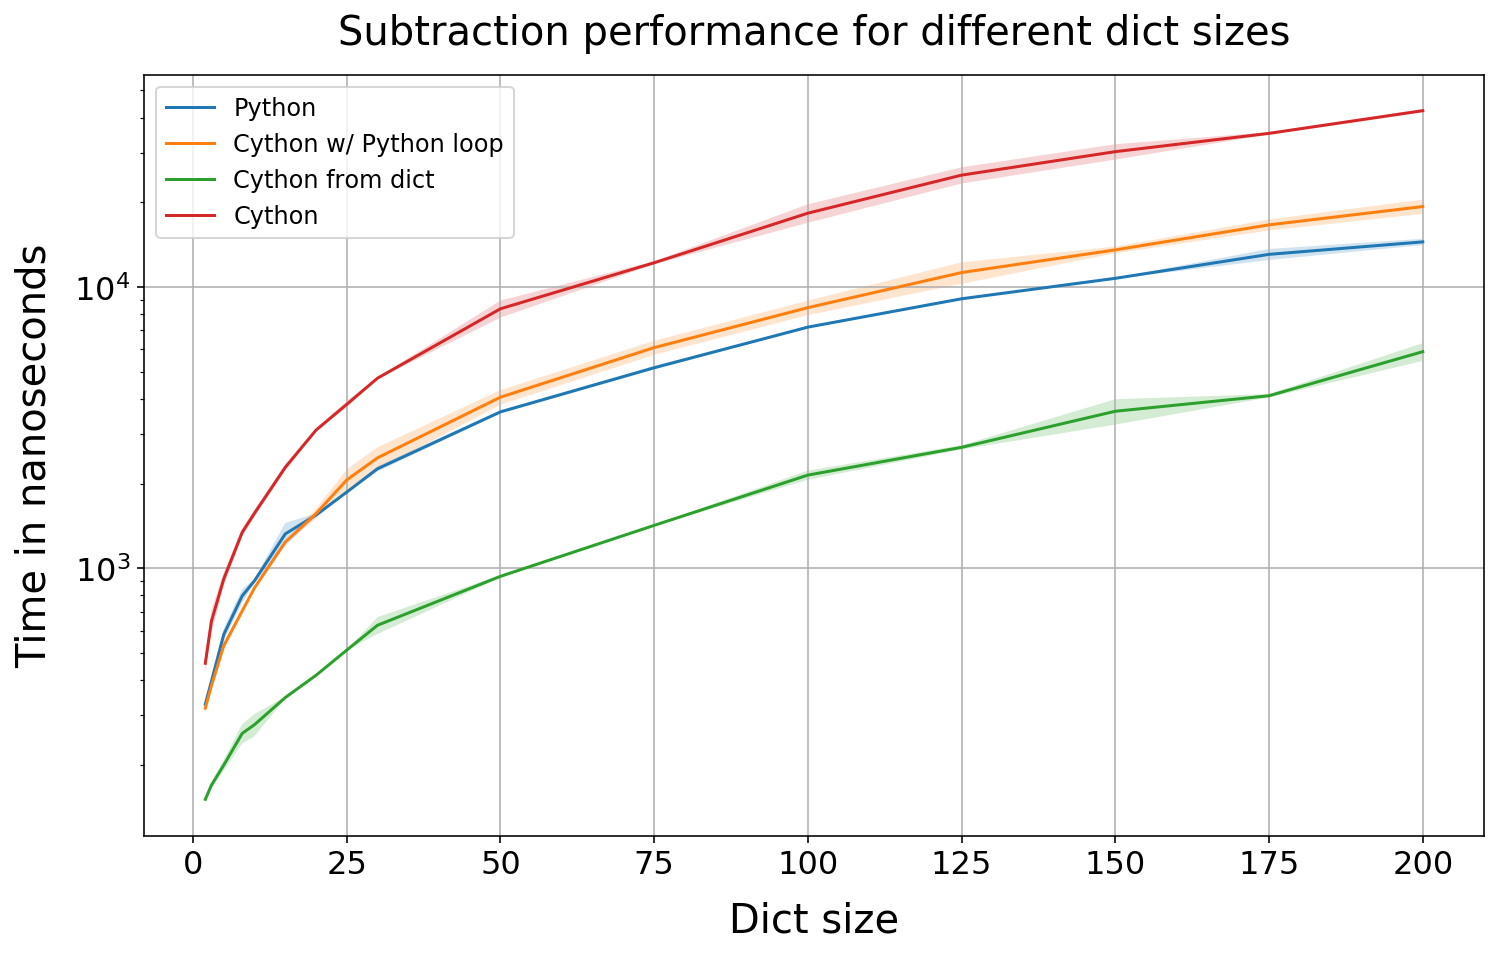

In [25]:
fig, ax = plt.subplots(figsize=(12, 7))

for method, time_results in sub_bench.items():
    avgs = [1e9 * tr.average for tr in time_results.values()]
    stds = [1e9 * tr.stdev   for tr in time_results.values()]
    lower = [avg - std for avg, std in zip(avgs, stds)]
    upper = [avg + std for avg, std in zip(avgs, stds)]
    ax.fill_between(list(time_results.keys()), lower, upper, interpolate=True, alpha=.2)
    ax.plot(list(time_results.keys()), avgs, label=method)
    
ax.legend()
ax.grid()
ax.set_title('Subtraction performance for different dict sizes', pad=15)
ax.set_xlabel('Dict size', labelpad=10)
ax.set_ylabel('Time in nanoseconds', labelpad=10)
ax.set_yscale('log')
fig.savefig('subtract_perf.png')

## Standard scaling

# Comparing initialization

In [ ]:
%load_ext Cython

In [104]:
%%cython --annotate
# distutils: language = c++

cimport cython

# C++
from cython.operator cimport dereference as deref, preincrement as inc, \
    predecrement as dec
from libcpp.utility cimport pair
from libcpp.map cimport map as cpp_map

import numpy as np

# Import the C-level symbols of numpy
cimport numpy as np

# Numpy must be initialized. When using numpy from C or Cython you must
# _always_ do that, or you will have segfaults
np.import_array()

#DTYPE = np.float64
ctypedef np.float64_t DTYPE_t

#ITYPE = np.intp
ctypedef np.intp_t ITYPE_t

cdef class IntFloatDict:
    
    cdef cpp_map[ITYPE_t, DTYPE_t] my_map

    @cython.boundscheck(False)
    @cython.wraparound(False)
    def __init__(self, np.ndarray[ITYPE_t, ndim=1] keys,
                       np.ndarray[DTYPE_t, ndim=1] values):
        cdef int i
        cdef int size = values.size
        # Should check that sizes for keys and values are equal, and
        # after should boundcheck(False)
        for i in range(size):
            self.my_map[keys[i]] = values[i]
            
    def __getitem__(self, int key):
        cdef cpp_map[ITYPE_t, DTYPE_t].iterator it = self.my_map.find(key)
        if it == self.my_map.end():
            # The key is not in the dict
            raise KeyError('%i' % key)
        return deref(it).second
    
    def __setitem__(self, int key, float value):
        self.my_map[key] = value
    
    def dot(self, IntFloatDict other):
        cdef DTYPE_t total
        cdef ITYPE_t key
        
        cdef cpp_map[ITYPE_t, DTYPE_t].iterator it = other.my_map.begin()
        cdef cpp_map[ITYPE_t, DTYPE_t].iterator end = other.my_map.end()
        
        while it != end:
            key = deref(it).first
            total += self.my_map[key] * other.my_map[key]
            inc(it)
        
        return total
    
    @cython.boundscheck(False)
    @cython.wraparound(False)
    def dot_numpy(self, np.ndarray[ITYPE_t, ndim=1] keys, np.ndarray[DTYPE_t, ndim=1] values):
        cdef DTYPE_t total
        
        cdef int i
        cdef int size = values.size
        
        for i in range(size):
            total += self.my_map[keys[i]] * values[i]
        
        return total
        

Numpy dot product.

In [106]:
ks = np.arange(30)
vs = np.arange(30).astype(float)
%timeit vs.dot(vs)

591 ns ± 145 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Cython dict dot product.

In [107]:
a = IntFloatDict(ks, vs)
b = IntFloatDict(ks, vs)
%timeit a.dot(b)

332 ns ± 2.56 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [108]:
a = IntFloatDict(ks, vs)
%timeit a.dot_numpy(ks, vs)

1.11 µs ± 138 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Initialization cost.

In [109]:
%timeit IntFloatDict(ks, vs)

5.11 µs ± 1.41 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Python dict dot product.

In [110]:
a = dict(zip(ks, vs))
b = dict(zip(ks, vs))
%timeit sum(a[k] * b[k] for k in a)

9.14 µs ± 1.38 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## Comparing initialization

In [186]:
%%cython --annotate
# distutils: language = c++

cimport cython

# C++
from cython.operator cimport dereference as deref, preincrement as inc, \
    predecrement as dec
from libcpp.utility cimport pair
from libcpp.map cimport map as cpp_map

import numpy as np

# Import the C-level symbols of numpy
cimport numpy as np

# Numpy must be initialized. When using numpy from C or Cython you must
# _always_ do that, or you will have segfaults
np.import_array()

#DTYPE = np.float64
ctypedef np.float64_t DTYPE_t

#ITYPE = np.intp
ctypedef np.intp_t ITYPE_t

cdef class IntFloatDict:
    
    cdef cpp_map[ITYPE_t, DTYPE_t] my_map

    @cython.boundscheck(False)
    @cython.wraparound(False)
    def __init__(self, list keys not None, list values not None):
        cdef int i
        cdef int size = len(keys)
        # Should check that sizes for keys and values are equal, and
        # after should boundcheck(False)
        for i in range(size):
            self.my_map[keys[i]] = values[i]
            
    def __getitem__(self, int key):
        cdef cpp_map[ITYPE_t, DTYPE_t].iterator it = self.my_map.find(key)
        if it == self.my_map.end():
            # The key is not in the dict
            raise KeyError('%i' % key)
        return deref(it).second
    
    def __setitem__(self, int key, float value):
        self.my_map[key] = value
            
    def dot(self, IntFloatDict other):
        cdef DTYPE_t total
        cdef ITYPE_t key
        
        cdef cpp_map[ITYPE_t, DTYPE_t].iterator it = other.my_map.begin()
        cdef cpp_map[ITYPE_t, DTYPE_t].iterator end = other.my_map.end()
        
        while it != end:
            key = deref(it).first
            total += self.my_map[key] * other.my_map[key]
            inc(it)
        
        return total
    
    @cython.boundscheck(False)
    @cython.wraparound(False)
    def dot_list(self, list keys not None, list values not None):
        cdef DTYPE_t total
        cdef ITYPE_t k
        cdef DTYPE_t v
        
        cdef int i
        cdef int size = len(values)
        
        for i in range(size):
            k = keys[i]
            v = values[i]
            total += self.my_map[k] * v
        
        return total

## sklearn example

In [18]:
import numpy as np
from sklearn.utils._fast_dict import IntFloatDict, argmin

keys = np.arange(100)
values = np.arange(100).astype(float)

cd = IntFloatDict(keys, values)
%time sum(v * v for _, v in cd)

d = dict(zip(keys, values))
%time sum(v * v for k, v in d.items())

CPU times: user 38 µs, sys: 0 ns, total: 38 µs
Wall time: 41 µs
CPU times: user 33 µs, sys: 0 ns, total: 33 µs
Wall time: 36.2 µs


328350.0

In [20]:
%timeit argmin(cd)

444 ns ± 4.27 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [22]:
%timeit min(d, key=d.get)

6.29 µs ± 169 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [29]:
%timeit np.empty(1000)

707 ns ± 126 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [35]:
%timeit cd[50] += 1

89.6 ns ± 5.75 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [36]:
%timeit d[50] += 1

433 ns ± 138 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
